In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

In [26]:
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data['cellType'] = data['cellType'].astype(str)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

([0, 1, 2, 3],
 [Text(0, 0, '2'), Text(1, 0, '0'), Text(2, 0, '3'), Text(3, 0, '1')])

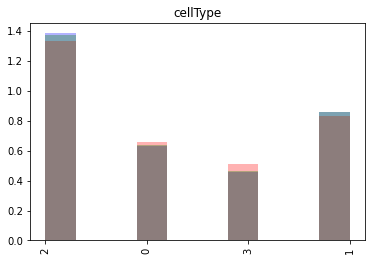

In [27]:
plt.hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['cellType'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(data['cellType'], alpha=0.3, color='g', density=True)
plt.title('cellType')
plt.xticks(rotation='vertical')

In [28]:
class_samples = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples)
class_weights = total_samples / class_samples

class_weight_dict = {int(k): v for k, v in class_weights.to_dict().items()}

In [29]:
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


三层卷积，池化。+64，32，16MPL。bc=16，lr=0.001。目前表现最佳。

In [30]:
input_shape = (27, 27, 3)
num_classes = 4
l2_coeff = 0.01

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 27, 27, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_19 (Bat  (None, 25, 25, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00005),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=4, average='macro')])

In [ ]:
epochs = 200
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-15)
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(test_data) // batch_size,
    class_weight=class_weight_dict
    , callbacks=[lr_reducer]
)

Epoch 1/200
247/247 [==============================] - 11s 41ms/step - loss: 17.0699 - accuracy: 0.5911 - precision_3: 0.6300 - recall_3: 0.5382 - f1_score: 0.5422 - val_loss: 15.5454 - val_accuracy: 0.3996 - val_precision_3: 0.3996 - val_recall_3: 0.3996 - val_f1_score: 0.1499 - lr: 0.0010
Epoch 2/200
247/247 [==============================] - 9s 36ms/step - loss: 12.5495 - accuracy: 0.6622 - precision_3: 0.7159 - recall_3: 0.5850 - f1_score: 0.6139 - val_loss: 8.5996 - val_accuracy: 0.4677 - val_precision_3: 0.4952 - val_recall_3: 0.4472 - val_f1_score: 0.2636 - lr: 0.0010
Epoch 3/200
247/247 [==============================] - 9s 36ms/step - loss: 9.2061 - accuracy: 0.6816 - precision_3: 0.7447 - recall_3: 0.6060 - f1_score: 0.6359 - val_loss: 5.1937 - val_accuracy: 0.7377 - val_precision_3: 0.7873 - val_recall_3: 0.6732 - val_f1_score: 0.6746 - lr: 0.0010
Epoch 4/200
247/247 [==============================] - 9s 36ms/step - loss: 6.9427 - accuracy: 0.6941 - precision_3: 0.7540 - rec

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
train_precision = history.history['precision_3']
val_precision = history.history['val_precision_3']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_precision, label='Training Precision')
plt.plot(epochs_range, val_precision, label='Validation Precision')

plt.legend()
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')

plt.show()

In [ ]:
train_recall = history.history['recall_3']
val_recall = history.history['val_recall_3']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')

plt.legend()
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')

plt.show()

In [ ]:
train_f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_f1, label='Training F1')
plt.plot(epochs_range, val_f1, label='Validation F1')

plt.legend()
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Recall')

plt.show()